# Fraud Detection

### Self Organizing Maps
(SOMs) can be a useful tool for fraud detection due to their ability to discover and represent complex patterns within data. SOMs are a type of unsupervised machine learning algorithm that can perform clustering and visualization tasks.

## Install MiniSom Package

In [72]:
!pip install MiniSom


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\jakrajew\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### Importing the libraries


In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [74]:
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler

## Dataset information


Statlog (Australian Credit Approval)

Additional Information

This file concerns credit card applications.  All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data.
  
This dataset is interesting because there is a good mix of attributes -- continuous, nominal with small numbers of values, and nominal with larger numbers of values.  There are also a few missing values.

Additional Information

There are 6 numerical and 8 categorical attributes.  The labels have been changed for the convenience of the statistical algorithms.  For example, attribute 4 originally had 3 labels p,g,gg and these have been changed to labels 1,2,3.
                             
- A1: 0,1    CATEGORICAL (formerly: a,b)
- A2: continuous.
- A3: continuous.
- A4: 1,2,3    CATEGORICAL  (formerly: p,g,gg)
 -A5: 1, 2,3,4,5, 6,7,8,9,10,11,12,13,14    CATEGORICAL (formerly: ff,d,i,k,j,aa,m,c,w, e, q, r,cc, x)
- A6: 1, 2,3, 4,5,6,7,8,9    CATEGORICAL (formerly: ff,dd,j,bb,v,n,o,h,z)
- A7: continuous.
- A8: 1, 0    CATEGORICAL (formerly: t, f)
- A9: 1, 0	CATEGORICAL (formerly: t, f)
- A10:  continuous.
- A11:  1, 0	    CATEGORICAL (formerly t, f)
- A12:  1, 2, 3    CATEGORICAL (formerly: s, g, p) 
- A13:  continuous.
- A14:  continuous.
- A15:   1,2  class attribute (formerly: +,-) 

## Importing the dataset

In [75]:
dataset = pd.read_csv('Credit_Card_Applications.csv')
dataset.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


In [76]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

## Feature Scaling


In [77]:
sc = MinMaxScaler(feature_range=(0, 1))
X_scaled = sc.fit_transform(X)

## Training the SOM


A rule of thumb to set the size of the grid for a dimensionality
reduction task is that it should contain 5*sqrt(N) neurons
where N is the number of samples in the dataset to analyze.

E.g. if your dataset has 150 samples, 5*sqrt(150) = 61.23
hence a map 8-by-8 should perform well.

In [78]:
import math
neurons = 5 * math.sqrt(len(dataset))
print(f'Number of neurons: {neurons}. Grid size: {math.ceil(math.sqrt(neurons))}x{math.ceil(math.sqrt(neurons))}')

Number of neurons: 131.33925536563697. Grid size: 12x12


In [79]:
som = MiniSom(
            x=12,
            y=12,
            input_len=15,
            sigma=1.0,
            learning_rate=0.1,
        )

In [88]:
som.random_weights_init(X_scaled)
som.train_random(data=X_scaled, num_iteration=10000)


## Visualizing the results


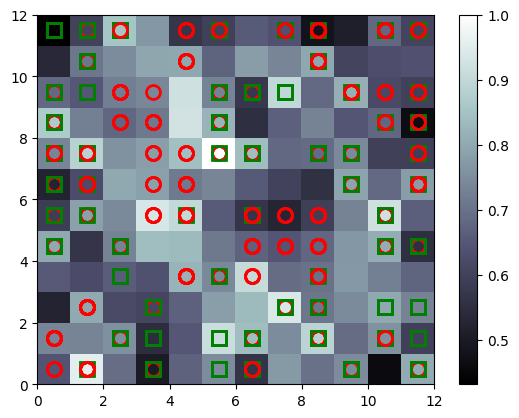

In [89]:
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map(scaling='mean').T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(X_scaled):
    w = som.winner(x)
    plot(
        w[0] + 0.5,
        w[1] + 0.5,
        markers[y[i]],
        markeredgecolor=colors[y[i]],
        markerfacecolor='None',
        markersize=10,
        markeredgewidth=2,
    )

## Explanation

The darker the neuron, the closer the neuron is to the winning node. The winning node is the neuron that is the most similar to its neighborhood. The white neurons are the outliers and potential frauds. Meaning that the customers that did get approved and are on the white neurons are far from any group that represents customers that got approval. We do not care about customers that did not get approved and are on outlier neurons. 

## Finding the frauds


Let's include neurons at a 0.9 threshold that include customers that got approval.

In [90]:
mappings = som.win_map(X_scaled)
frauds = np.concatenate(
    (
        mappings[(1, 0)], 
        mappings[(5, 7)], 
        mappings[(7, 2)],
        mappings[(10, 5)],
    ), 
    axis=0)

## Printing the Fraunch Clients (IDs)

In [91]:
frauds = sc.inverse_transform(frauds)
print(frauds[:, 0])

[15608595. 15719940. 15761158. 15711742. 15761733. 15770995. 15666166.
 15605872. 15736399. 15766734. 15667934. 15665087. 15680643. 15692137.
 15676909. 15631685. 15614813. 15571081. 15625501. 15589541. 15598574.
 15702571. 15646190. 15689692. 15672357.]


## Training the Neural Network to predict the probability of customer fraud

Going from unsupervised to supervised deep learning. By labeling the customers by potential fraunch behavior we get an idea of what a fraud customer looks like. We can then train a supervised deep learning model to predict the probability of a customer being a fraud. We will use all the features of the customer to predict the probability of fraud except the customer ID. Even the "Class" (approved or not) feature will be used as a dependent variable.

In [94]:
customers = dataset
customers.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


Mapping potential fraud to their respective customers. 1 means that the customer is a potential fraud and 0 means that the customer is not a potential fraud.

In [102]:
customers['fraud'] = customers['CustomerID'].isin(frauds[:, 0]).astype(int)
customers.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class,fraud
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1,0
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1,0


### Creating the matrix of features

In [103]:
X = customers.iloc[:, 1:-1].values
y = customers.iloc[:, -1].values

### Standardizing the data

In [104]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

### Building the ANN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(units=64, activation='relu', input_shape=(16,)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))